# RIM multi-step-ahead prediction

This notebook explores how to predict the previously defined high-level metric *Efficiency*.
The code wraps up the data processing, the model training and testing phases, and the model export. 
Here we use RIM

## Imports

In [1]:
import sys
from math import sqrt
import numpy as np
from numpy import array

from scipy.signal import savgol_filter

from sklearn.metrics import mean_squared_error

import pandas as pd

from matplotlib import pyplot

import tensorflow as tf

from keras.layers import Bidirectional
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers import Dense

from keras.models import Sequential

from gcd_data_manipulation import data_aggregation
from gcd_data_manipulation import load_data
from gcd_data_manipulation import scale_values
from gcd_data_manipulation import series_to_supervised
from gcd_data_manipulation import reshape_data

from multistepahead_model_evaluation import evaluate_forecast
from multistepahead_model_evaluation import walk_forward_validation

2022-04-20 12:00:41.148349: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Data preprocessing

In [2]:
JOBID = 3418339

columns_to_consider = [
    "end time",
    "CPU rate",
    "canonical memory usage",
    "assigned memory usage",
    "unmapped page cache",
    "total page cache",
    "maximum memory usage",
    "disk I/O time",
    "local disk space usage",
    "maximum CPU rate",
    "maximum disk IO time",
    "cycles per instruction",
    "memory accesses per instruction",
    "Efficiency",  # target metric
]

readings_df = load_data(
    "../data/task-usage_job-ID-%i_total.csv" % JOBID, columns_to_consider
)

In [3]:
readings_df.head(10)

,end time,CPU rate,canonical memory usage,assigned memory usage,unmapped page cache,total page cache,maximum memory usage,disk I/O time,local disk space usage,maximum CPU rate,maximum disk IO time,cycles per instruction,memory accesses per instruction,Efficiency
13,900000000,0.03418,0.08752,0.09839,0.001888,0.002773,0.08887,0.000274,0.000212,0.1030,0.057860,1.859,0.003949,0.439211
14,900000000,0.03528,0.08740,0.09900,0.000626,0.001501,0.08862,0.000224,0.000215,0.1229,0.022710,1.976,0.004837,0.441883
15,900000000,0.03644,0.08704,0.09912,0.000799,0.001247,0.08862,0.000242,0.000352,0.1141,0.030360,1.947,0.004163,0.495868
16,900000000,0.03845,0.08728,0.09912,0.000713,0.001493,0.08850,0.000192,0.000215,0.1082,0.029720,1.913,0.004048,0.447112
17,900000000,0.03790,0.08716,0.09912,0.000880,0.001490,0.08838,0.000077,0.000359,0.1155,0.004997,2.047,0.004314,0.501464
18,900000000,0.03406,0.08704,0.09912,0.001905,0.002449,0.08838,0.000076,0.000349,0.1353,0.014010,1.820,0.003891,0.490515
19,900000000,0.03699,0.08704,0.09912,0.000817,0.001331,0.08850,0.000194,0.000358,0.1348,0.035400,1.894,0.003909,0.499052
20,900000000,0.03271,0.08704,0.09912,0.001007,0.001562,0.08838,0.000100,0.000359,0.1173,0.011510,1.690,0.003473,0.491831
21,900000000,0.03540,0.08704,0.09900,0.001642,0.002132,0.08838,0.000109,0.000216,0.1107,0.011220,2.029,0.004776,0.441225
22,900000000,0.03467,0.08716,0.09912,0.002350,0.002960,0.08875,0.000093,0.000358,0.1248,0.009567,1.900,0.004520,0.495335


### Generate timestamp to interpolate NaN

In this part, we are taking the end time of the observation period, and we are converting them to datetime values.
As start time, we consider the 1st of May, 2011, PT. We add this value to the end time values.

In [4]:
readings_df["datetime"] = timestamps_readings = [
    pd.Timestamp(int(t / 1000000) + 1304233200, tz="US/Pacific", unit="s")
    for t in readings_df["end time"].values
]

Here, we are setting the datetime column as index,as needed by the interpolate function from pandas

In [5]:
readings_df.set_index("datetime", inplace=True)

In [6]:
readings_df.head()

,end time,CPU rate,canonical memory usage,assigned memory usage,unmapped page cache,total page cache,maximum memory usage,disk I/O time,local disk space usage,maximum CPU rate,maximum disk IO time,cycles per instruction,memory accesses per instruction,Efficiency
datetime,,,,,,,,,,,,,,
2011-05-01 00:15:00-07:00,900000000,0.03418,0.08752,0.09839,0.001888,0.002773,0.08887,0.000274,0.000212,0.1030,0.057860,1.859,0.003949,0.439211
2011-05-01 00:15:00-07:00,900000000,0.03528,0.08740,0.09900,0.000626,0.001501,0.08862,0.000224,0.000215,0.1229,0.022710,1.976,0.004837,0.441883
2011-05-01 00:15:00-07:00,900000000,0.03644,0.08704,0.09912,0.000799,0.001247,0.08862,0.000242,0.000352,0.1141,0.030360,1.947,0.004163,0.495868
2011-05-01 00:15:00-07:00,900000000,0.03845,0.08728,0.09912,0.000713,0.001493,0.08850,0.000192,0.000215,0.1082,0.029720,1.913,0.004048,0.447112
2011-05-01 00:15:00-07:00,900000000,0.03790,0.08716,0.09912,0.000880,0.001490,0.08838,0.000077,0.000359,0.1155,0.004997,2.047,0.004314,0.501464


Use interpolation to remove nan. Sources:
- https://stackoverflow.com/questions/49308530/missing-values-in-time-series-in-python
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html



In [7]:
readings_df.interpolate(method="time", limit_direction="both", inplace=True)

### Aggregate data

In [8]:
def q95(x):
    return x.quantile(0.95)

def q75(x):
    return x.quantile(0.75)

def q25(x):
    return x.quantile(0.25)




In [9]:
readings_df_x = readings_df.groupby('end time').agg([('mean', 'mean'), ('median', 'median'), ('min', 'min'), ('max','max'), ('q25', q25), ('q75', q75), ('q95', q95), ('std', 'std')])

In [10]:
readings_df_x

CPU rate                                               \
                   mean   median      min      max      q25      q75   
end time                                                               
900000000      0.035042  0.03528  0.02972  0.03900  0.03406  0.03674   
1200000000     0.033072  0.03326  0.02786  0.03711  0.03149  0.03491   
1500000000     0.032797  0.03284  0.02838  0.03650  0.03131  0.03455   
1800000000     0.032152  0.03198  0.02753  0.03717  0.03064  0.03363   
2100000000     0.032904  0.03235  0.02805  0.03796  0.03174  0.03424   
...                 ...      ...      ...      ...      ...      ...   
2505000000000  0.037400  0.03735  0.03320  0.04242  0.03577  0.03906   
2505300000000  0.036892  0.03687  0.03253  0.04059  0.03485  0.03864   
2505600000000  0.035126  0.03442  0.03107  0.04034  0.03314  0.03687   
2505900000000  0.035702  0.03528  0.03186  0.04419  0.03339  0.03662   
2506200000000  0.036736  0.03644  0.03278  0.04596  0.03436  0.03802   

                                  canonical memory usage           ...  \
                    q95       std                   mean   median  ...   
end time                                                           ...   
900000000      0.038340  0.002287               0.087198  0.08716  ...   
1200000000     0.036512  0.002358               0.086914  0.08691  ...   
1500000000     0.036214  0.002347               0.086879  0.08691  ...   
1800000000     0.035912  0.002360               0.086869  0.08691  ...   
2100000000     0.037402  0.002395               0.087110  0.08704  ...   
...                 ...       ...                    ...      ...  ...   
2505000000000  0.040818  0.002506               0.086642  0.08655  ...   
2505300000000  0.040384  0.002328               0.086651  0.08667  ...   
2505600000000  0.039272  0.002597               0.086642  0.08655  ...   
2505900000000  0.040454  0.002911               0.086642  0.08655  ...   
2506200000000  0.042044  0.003088               0.086642  0.08655  ...   

              memory accesses per instruction           Efficiency            \
                                          q95       std       mean    median   
end time                                                                       
900000000                            0.004750  0.000411   0.481978  0.492248   
1200000000                           0.004434  0.000320   0.477496  0.486884   
1500000000                           0.004468  0.000350   0.476892  0.487241   
1800000000                           0.004500  0.000300   0.475728  0.486597   
2100000000                           0.004728  0.000462   0.477995  0.489115   
...                                       ...       ...        ...       ...   
2505000000000                        0.004291  0.000339   0.491919  0.496250   
2505300000000                        0.004219  0.000342   0.491032  0.495129   
2505600000000                        0.004291  0.000407   0.487893  0.491817   
2505900000000                        0.004413  0.000455   0.488857  0.492573   
2506200000000                        0.004469  0.000413   0.490708  0.494102   

                                                                           
                    min       max       q25       q75       q95       std  
end time                                                                   
900000000      0.436230  0.503013  0.485122  0.498103  0.501044  0.023814  
1200000000     0.432434  0.498235  0.480615  0.493086  0.497185  0.023934  
1500000000     0.432217  0.497277  0.481486  0.492368  0.496901  0.024443  
1800000000     0.430512  0.498584  0.479975  0.492232  0.496808  0.025237  
2100000000     0.434463  0.500457  0.481746  0.494727  0.499674  0.024773  
...                 ...       ...       ...       ...       ...       ...  
2505000000000  0.438190  0.505653  0.490819  0.499660  0.503278  0.016719  
2505300000000  0.437909  0.502709  0.489853  0.499242  0.502358  0.015752  
250560000000

<AxesSubplot:xlabel='end time'>

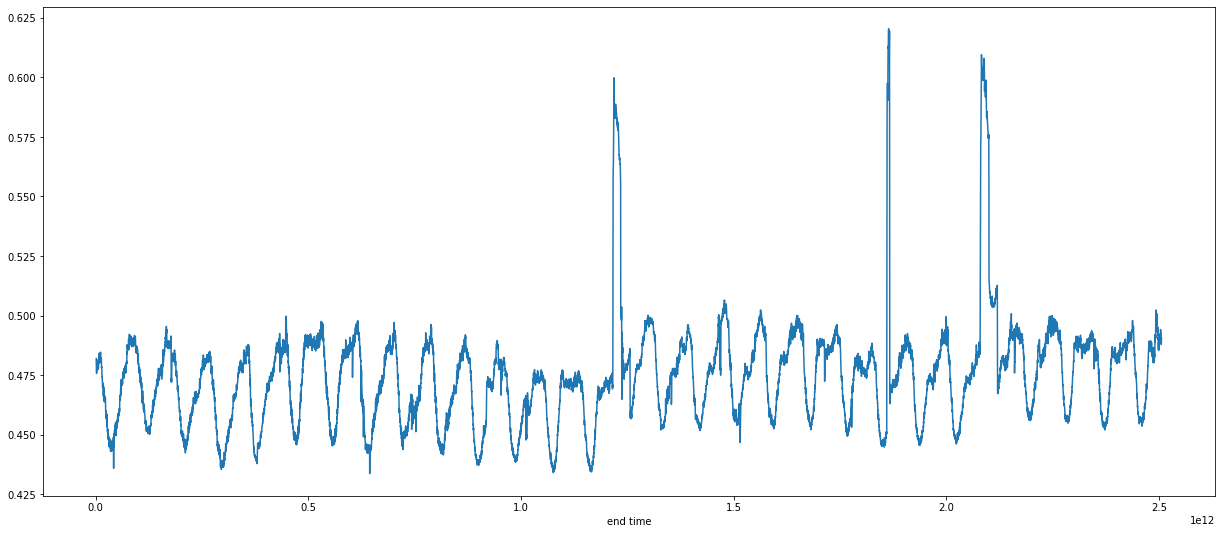

In [11]:
pyplot.figure(figsize=(21, 9))

readings_df_x["Efficiency"]['mean'].plot()

In [12]:
readings_df = readings_df_x[columns_to_consider[1:-1]]
readings_df["Efficiency"] = readings_df_x["Efficiency"]["mean"].values
readings_df

/tmp/ipykernel_1281587/2794251573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readings_df["Efficiency"] = readings_df_x["Efficiency"]["mean"].values


CPU rate                                               \
                   mean   median      min      max      q25      q75   
end time                                                               
900000000      0.035042  0.03528  0.02972  0.03900  0.03406  0.03674   
1200000000     0.033072  0.03326  0.02786  0.03711  0.03149  0.03491   
1500000000     0.032797  0.03284  0.02838  0.03650  0.03131  0.03455   
1800000000     0.032152  0.03198  0.02753  0.03717  0.03064  0.03363   
2100000000     0.032904  0.03235  0.02805  0.03796  0.03174  0.03424   
...                 ...      ...      ...      ...      ...      ...   
2505000000000  0.037400  0.03735  0.03320  0.04242  0.03577  0.03906   
2505300000000  0.036892  0.03687  0.03253  0.04059  0.03485  0.03864   
2505600000000  0.035126  0.03442  0.03107  0.04034  0.03314  0.03687   
2505900000000  0.035702  0.03528  0.03186  0.04419  0.03339  0.03662   
2506200000000  0.036736  0.03644  0.03278  0.04596  0.03436  0.03802   

                                  canonical memory usage           ...  \
                    q95       std                   mean   median  ...   
end time                                                           ...   
900000000      0.038340  0.002287               0.087198  0.08716  ...   
1200000000     0.036512  0.002358               0.086914  0.08691  ...   
1500000000     0.036214  0.002347               0.086879  0.08691  ...   
1800000000     0.035912  0.002360               0.086869  0.08691  ...   
2100000000     0.037402  0.002395               0.087110  0.08704  ...   
...                 ...       ...                    ...      ...  ...   
2505000000000  0.040818  0.002506               0.086642  0.08655  ...   
2505300000000  0.040384  0.002328               0.086651  0.08667  ...   
2505600000000  0.039272  0.002597               0.086642  0.08655  ...   
2505900000000  0.040454  0.002911               0.086642  0.08655  ...   
2506200000000  0.042044  0.003088               0.086642  0.08655  ...   

              cycles per instruction memory accesses per instruction  \
                                 std                            mean   
end time                                                               
900000000                   0.116697                        0.004107   
1200000000                  0.115363                        0.003897   
1500000000                  0.118224                        0.003872   
1800000000                  0.109008                        0.004027   
2100000000                  0.133050                        0.004128   
...                              ...                             ...   
2505000000000               0.098550                        0.003809   
2505300000000               0.099457                        0.003777   
2505600000000               0.124989                        0.003708   
2505900000000               0.133782                        0.003749   
2506200000000               0.131300                        0.003711   

                                                                           \
                 median       min       max       q25       q75       q95   
end time                                                                    
900000000      0.004048  0.003306  0.004837  0.003902  0.004373  0.004750   
1200000000     0.003928  0.003336  0.004458  0.003696  0.004089  0.004434   
1500000000     0.003848  0.003275  0.004565  0.003654  0.004097  0.004468   
1800000000     0.004051  0.003451  0.004576  0.003832  0.004215  0.004500   
2100000000     0.004099  0.003269  0.004864  0.003732  0.004488  0.004728   
...                 ...       ...       ...       ...       ...       ...   
2505000000000  0.003778  0.003233  0.004333  0.003534  0.004131  0.004291   
2505300000000  0.003819  0.003272  0.004504  0.003459  0.004003  0.004219   
2505600000000  0.003671  0.003027  0.004423  0.003369  0.004039  0.004291   
2505900000000  0.003605  0.003186  0

### Scale values

In [13]:
values = readings_df.values

scaled, scaler = scale_values(values)

### Create train-validation-test sets

In [14]:
n_train = int(scaled.shape[0] * 0.6)
n_validation = int(scaled.shape[0] * 0.2)
train = scaled[:n_train, :]
validation = scaled[n_train : (n_train + n_validation), :]
test = scaled[(n_train + n_validation) :, :]

print("Train shape:", train.shape)
print("Validation shape:", validation.shape)
print("Test shape:", test.shape)

Train shape: (5011, 97)
Validation shape: (1670, 97)
Test shape: (1671, 97)


### Reshape the input data without Efficiency - __no_eff__

Reshape data, keeping out efficiency, that is our *target metric*, and according to the defined lookback and lookahead values, namely:
- lookback: 24 sampling steps
- lookahead: 3 sampling steps

We perform the reshaping, using the `reshape_data` function present in the `gcd_data_manipulation.py` functions collector.


In [15]:
n_input = 24
n_out = 3

In [16]:
train_x, train_y = reshape_data(
    train, n_input, n_out, input_cols_interval=(0, -1)
)
print(train_x.shape, train_y.shape)

validation_x, validation_y = reshape_data(
    validation, n_input, n_out, input_cols_interval=(0, -1)
)
print(validation_x.shape, validation_y.shape)

test_x, test_y = reshape_data(
    test, n_input, n_out, input_cols_interval=(0, -1)
)
print(test_x.shape, test_y.shape)

(4985, 24, 96) (4985, 3)
(1644, 24, 96) (1644, 3)
(1645, 24, 96) (1645, 3)


## Create RIM model

In [22]:
from RIM import RIM

In [23]:
rim_model = RIM('cuda', 96, 24, 6, 4, 'LSTM', 4, True)

AssertionError: Torch not compiled with CUDA enabled

In [24]:
import torch

out, h, c = rim_model(train_x)

TypeError: 'int' object is not callable